In [116]:
%load_ext autoreload
%autoreload 2

import os
import sys

sys.path.append('..')
from single_cell_analysis.datasets import sciplex
from single_cell_analysis.ot import sinkhorn

from pathlib import Path

import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
from tqdm import tqdm

from geomloss import SamplesLoss
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.2 scipy==1.6.1 pandas==1.2.2 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.0 leidenalg==0.8.3


In [175]:
# change this path with the path you have sciplex dataset
data_path = Path('/home/yavuz/data/sciplex')
figures_path = Path('figures')
figures_path.mkdir()
device = torch.device('cpu')
sinkhorn_geomloss = SamplesLoss(loss="sinkhorn", scaling=0.9, p=1, debias=True).to(device)
sinkhorn_cuturi = sinkhorn.SinkhornDistance(eps=0.1, max_iter=100).to(device)

In [4]:
sciplex2 = sciplex.SciPlex2(data_path / 'sciplex2', preprocess=True).dataset

In [5]:
sciplex2.shape

(24189, 35915)

In [101]:
def extract_sets_from_perturbations(dataset, group_by:list=['perturbation_raw']):
    set_labels = []
    set_values = []
    for group, indices in dataset.obs.groupby(group_by).indices.items():
        set_labels.append(group)
        set_values.append(dataset[indices])
    return set_labels, set_values

import math

def sinkhorn_distances_among_sets(sets, labels, sample_size=None, sample_count=None, batch_size=100):
    if sample_size is not None and sample_count is not None:
        result_sets = []
        result_labels = []
        for set_idx, set in enumerate(sets):
            for i in range(sample_count):
                random_idx = np.random.randint(len(sets), size=sample_size)
                result_sets.append(set[random_idx])
                result_labels.append(labels[set_idx])
        sets = result_sets
        labels = result_labels
        
    pairs = torch.combinations(torch.arange(len(sets)), 2)
    
    distance_matrix = torch.zeros((len(sets),len(sets)))
    for idx in tqdm(range(math.ceil(len(pairs) / batch_size))):
        slice_ = slice(idx * batch_size, min(idx * (batch_size + 1), len(pairs)))
        batch_1 = sets[pairs[slice_, 0]].obsm['X_umap']
        batch_2 = sets[pair[slice_, 1]].obsm['X_umap']
        dist = sinkhorn_geomloss(torch.from_numpy(batch_1).to(device), torch.from_numpy(batch_2).to(device))
        distance_matrix[pair[0], pair[1]] = dist
        distance_matrix[pair[1], pair[0]] = dist    
    return distance_matrix, sets, labels

import umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def plot_embeddings_from_distance_matrix(distance_matrix, range_=None, labels=None, title=None, n_clusters=None):
    pca_ = PCA(n_components=2)
    pca_.fit(distance_matrix.numpy())
    embeddings = pca_.transform(distance_matrix.numpy())
    # treat = np.array([c[0] for c in comb])
    # dose = np.array([c[1] for c in comb])
    # treat_dose = np.array([t + '_' + str(d) for t, d in zip(treat,dose)])
    # for t in np.unique(treat):
    if range_ is not None:
        embeddings = embeddings[range_,:]
        labels = labels[range_]

    if type(labels[0]) == str:
        sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels)
    else:
        norm = colors.LogNorm()
        sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels, hue_norm=norm, palette=sns.color_palette("flare_r", as_cmap=True))
    # sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1])
    plt.title(f'Embeddings for treatment distributions: {title}')
    plt.legend(bbox_to_anchor=(1.05,1), ncol=2)
    
    if n_clusters is not None:
        kmeans = KMeans(n_clusters=n_clusters).fit(embeddings)
        clusters = kmeans.labels_.astype(str)
        plt.figure()
        sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=clusters)
        plt.title(f'Embeddings for treatment distributions: {title} (KMeans)')
        plt.legend(bbox_to_anchor=(1.05,1), ncol=2)
        return clusters
    
def add_clusters(adata, sample, n_clusters, cluster_labels):
    cluster_indices = [s.obs.index for s in sample]
    for label, index in zip(cluster_labels, cluster_indices):
        adata.obs.at[index, f'sinkhorn_cluster_{n_clusters}'] = label

In [7]:
set_labels, set_values = extract_sets_from_perturbations(sciplex2)

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
sinkhorn_matrix, set_values, set_labels = sinkhorn_distances_among_sets(set_values, set_labels)

100%|██████████| 496/496 [03:41<00:00,  2.24it/s]


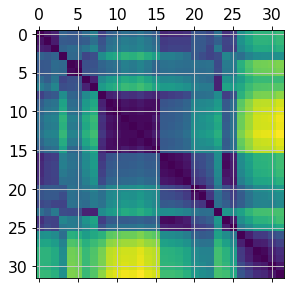

In [9]:
plt.matshow(sinkhorn_matrix)

In [10]:
labels_dose = [float(l.split("'")[3]) for l in set_labels]
labels_dose = [0.0000001 if l == 0.0 else l for l in labels_dose]

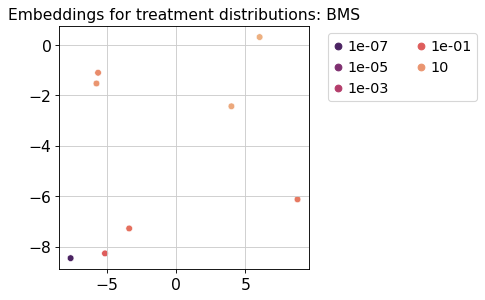

In [17]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix, range_=slice(0,8), labels=labels_dose, title='BMS')

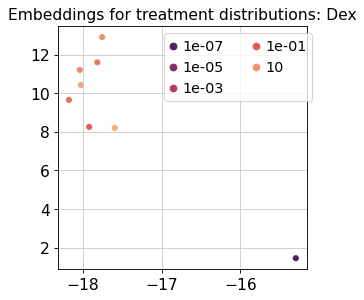

In [18]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix, range_=slice(8,16), labels=labels_dose, title='Dex')

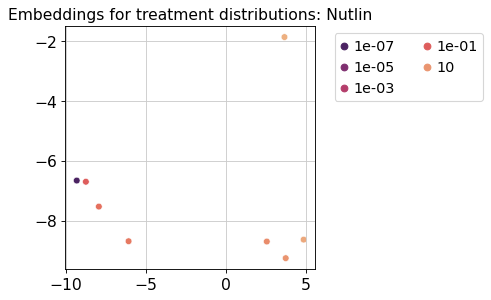

In [19]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix, range_=slice(16,24), labels=labels_dose, title='Nutlin')

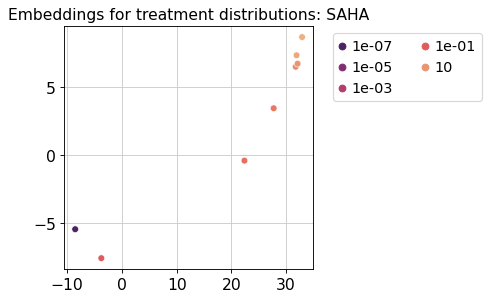

In [20]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix, range_=slice(24,32), labels=labels_dose, title='SAHA')

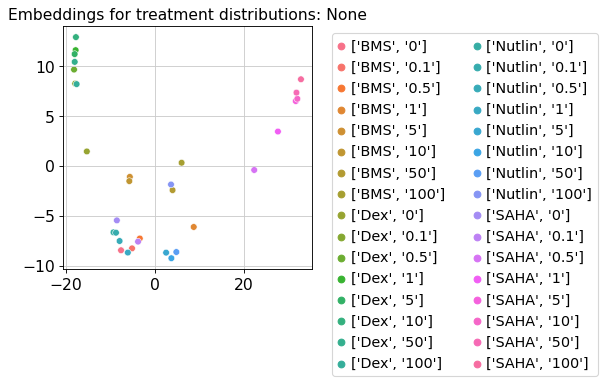

In [21]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix, labels=set_labels)

In [22]:
sinkhorn_matrix_size_100_sample_3, sample_sets, sample_labels = sinkhorn_distances_among_sets(set_values, set_labels, sample_size=100, sample_count=3)

/home/yavuz/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
100%|██████████| 4560/4560 [04:26<00:00, 17.12it/s]


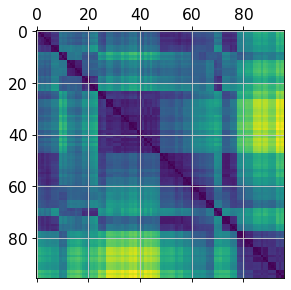

In [23]:
plt.matshow(sinkhorn_matrix_size_100_sample_3)

In [25]:
sample_labels_dose = [float(l.split("'")[3]) for l in sample_labels]
sample_labels_dose = [0.0000001 if l == 0.0 else l for l in sample_labels_dose]

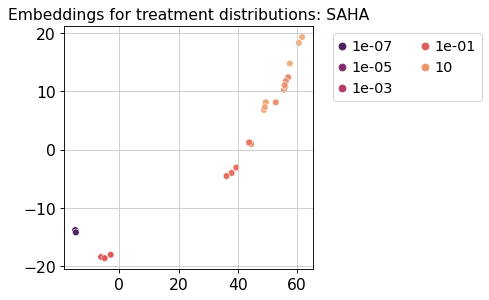

In [26]:

plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, range_=slice(72,96), labels=sample_labels_dose, title='SAHA')

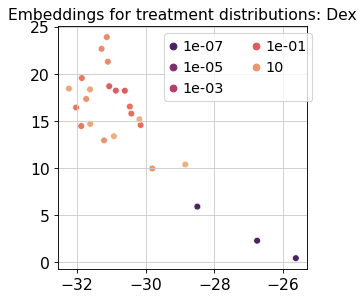

In [27]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, range_=slice(24,48), labels=sample_labels_dose, title='Dex')

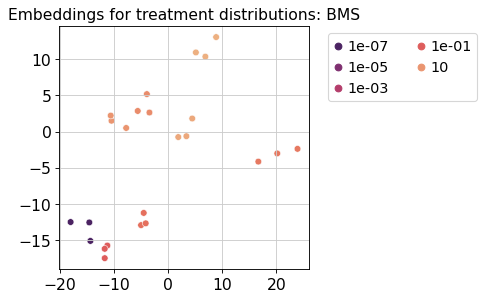

In [28]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, range_=slice(0,24), labels=sample_labels_dose, title='BMS')

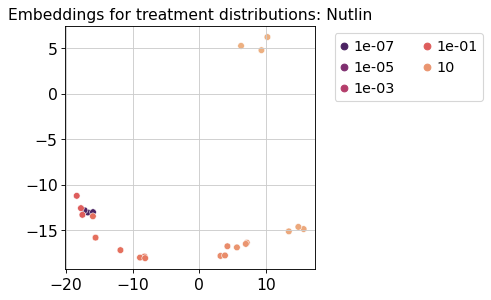

In [29]:
plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, range_=slice(48,72), labels=sample_labels_dose, title='Nutlin')

## Clustering in embedding space

In [30]:
sc.tl.leiden(sciplex2)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:18)


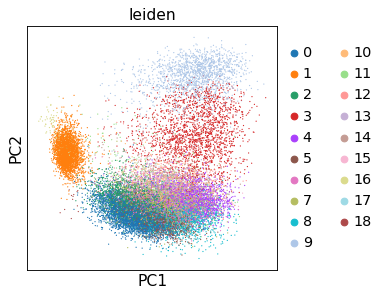

In [31]:
sc.pl.pca(sciplex2, color='leiden')

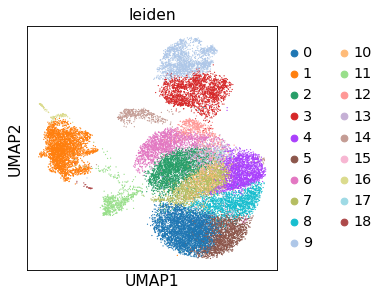

In [32]:
sc.pl.umap(sciplex2, color='leiden')

In [ ]:
len(cluster_labels)

In [33]:
cluster_indices = [s.obs.index for s in sample_sets]

In [ ]:
len(cluster_indices)

In [34]:
sciplex2.obs['sinkhorn_cluster'] = '-1'

In [35]:
sciplex2.obs['sinkhorn_cluster'].unique()

array(['-1'], dtype=object)

In [36]:
for label, index in zip(kmeans_clusters_18, cluster_indices):
    sciplex2.obs.at[index, 'sinkhorn_cluster_18'] = label

NameError: name 'cluster_labels' is not defined

In [ ]:
sciplex2.obs['sinkhorn_cluster']

In [ ]:
(sciplex2.obs['sinkhorn_cluster'] != '-1').value_counts()

In [ ]:
sc.pl.umap(sciplex2[sciplex2.obs['sinkhorn_cluster'] != '-1'], color=['sinkhorn_cluster'])

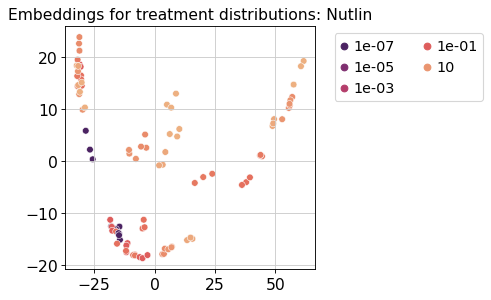

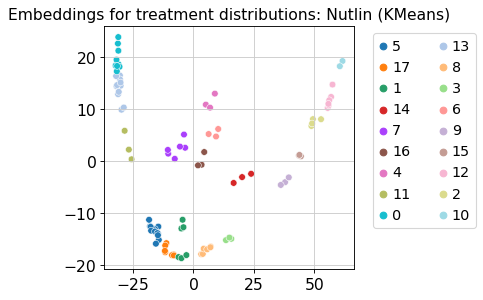

In [80]:
kmeans_clusters_18 = plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, labels=sample_labels_dose, title='Nutlin', n_clusters=18)

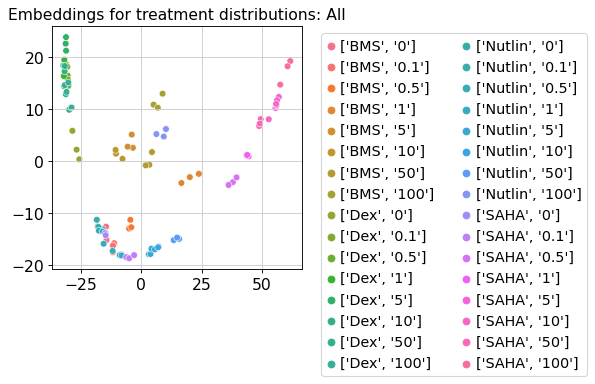

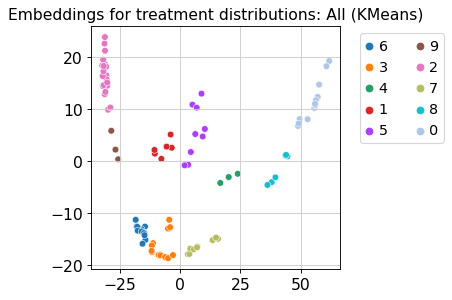

In [65]:
kmeans_clusters_10 = plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, labels=sample_labels, title='All', n_clusters=10)

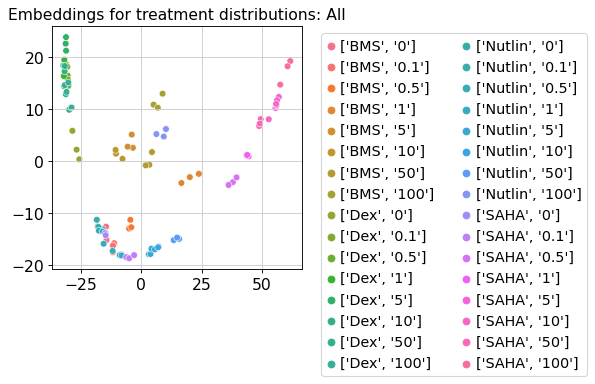

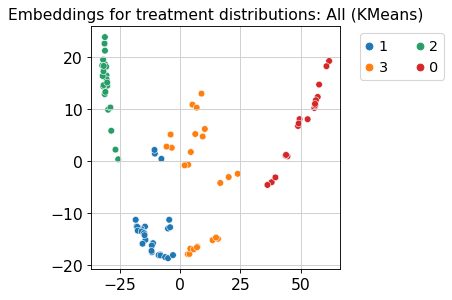

In [66]:
kmeans_clusters_4 = plot_embeddings_from_distance_matrix(distance_matrix=sinkhorn_matrix_size_100_sample_3, labels=sample_labels, title='All', n_clusters=4)

In [44]:
sciplex2

AnnData object with n_obs × n_vars = 24189 × 35915
    obs: 'perturbation_raw', 'cell_line', 'treatment', 'dose', 'BMS', 'Dex', 'Nutlin', 'SAHA', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'leiden', 'sinkhorn_cluster'
    var: 'gene_ids', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'neighbors', 'pca', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [45]:
add_clusters(sciplex2, sample_sets, 18, kmeans_clusters_18)

In [46]:
sciplex2

AnnData object with n_obs × n_vars = 24189 × 35915
    obs: 'perturbation_raw', 'cell_line', 'treatment', 'dose', 'BMS', 'Dex', 'Nutlin', 'SAHA', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'leiden', 'sinkhorn_cluster', 'sinkhorn_cluster_18'
    var: 'gene_ids', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'neighbors', 'pca', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

... storing 'sinkhorn_cluster_10' as categorical


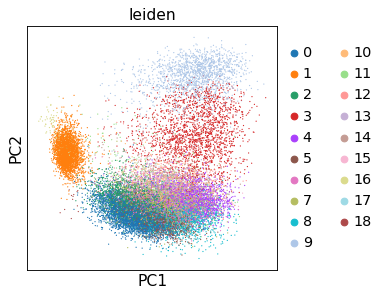

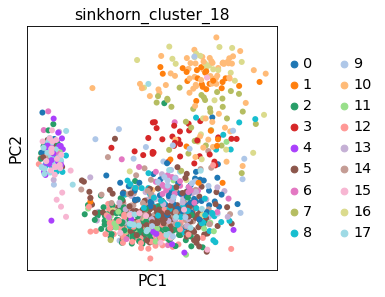

In [77]:
sc.pl.pca(sciplex2, color='leiden')
sc.pl.pca(sciplex2[sciplex2.obs['sinkhorn_cluster_18'] != 'nan'], color='sinkhorn_cluster_18')

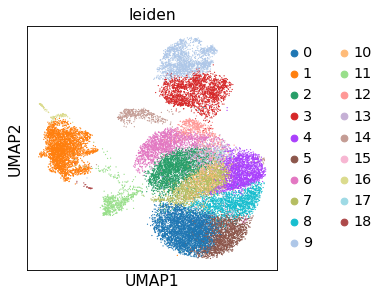

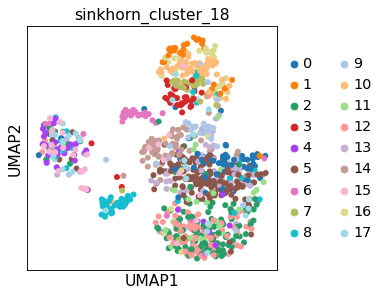

In [78]:
sc.pl.umap(sciplex2, color='leiden')
sc.pl.umap(sciplex2[sciplex2.obs['sinkhorn_cluster_18'] != 'nan'], color='sinkhorn_cluster_18')

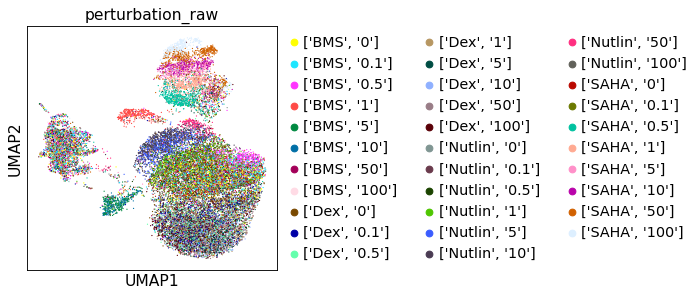

In [87]:
sc.pl.umap(sciplex2, color=['perturbation_raw'])

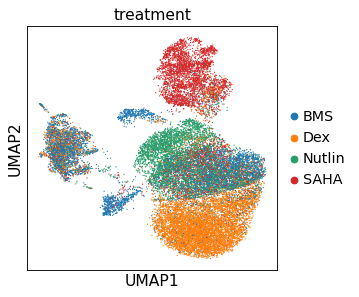

In [82]:
sc.pl.umap(sciplex2, color='treatment')

In [ ]:
sciplex2.obs()

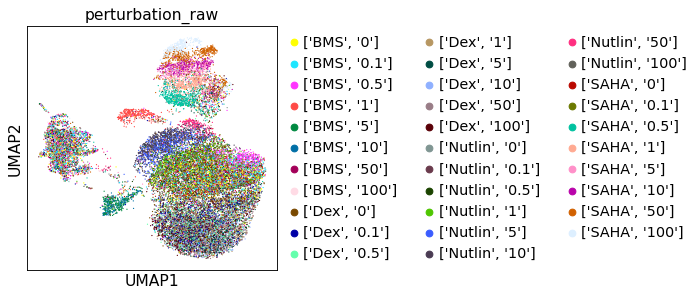

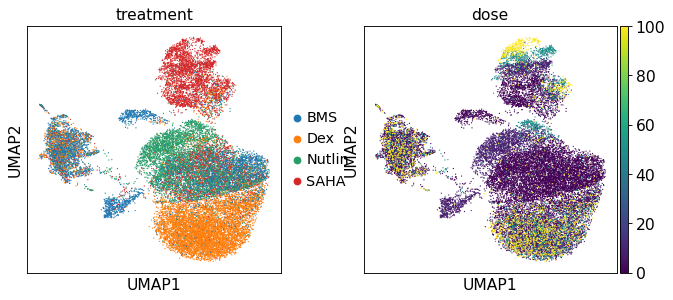

In [84]:

sc.pl.umap(sciplex2, color=['treatment','dose'])

In [81]:
sciplex2

AnnData object with n_obs × n_vars = 24189 × 35915
    obs: 'perturbation_raw', 'cell_line', 'treatment', 'dose', 'BMS', 'Dex', 'Nutlin', 'SAHA', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'leiden', 'sinkhorn_cluster', 'sinkhorn_cluster_18', 'sinkhorn_cluster_10'
    var: 'gene_ids', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'neighbors', 'pca', 'umap', 'leiden', 'leiden_colors', 'sinkhorn_cluster_18_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [67]:
add_clusters(sciplex2, sample_sets, 10, kmeans_clusters_10)

In [60]:
sinkhorn_matrix_size_100_sample_10, sample_sets_10, sample_labels_10 = sinkhorn_distances_among_sets(set_values, set_labels, sample_size=100, sample_count=10)

  0%|          | 0/511 [00:00<?, ?it/s]


TypeError: only integer tensors of a single element can be converted to an index

In [105]:
sahaasample_labels.index("['Dex', '10']")

39

In [106]:
sample_labels.index("['SAHA', '100']")

93

In [ ]:
"['SAHA', '100']"

In [109]:
dex_10

View of AnnData object with n_obs × n_vars = 100 × 35915
    obs: 'perturbation_raw', 'cell_line', 'treatment', 'dose', 'BMS', 'Dex', 'Nutlin', 'SAHA', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes'
    var: 'gene_ids', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
dex_10.X_pca()

In [112]:
dex_10.obsm['X_pca'].value()

AttributeError: 'ArrayView' object has no attribute 'value'

In [118]:
dex_10_vs_saha_100 = sinkhorn_cuturi(torch.from_numpy(dex_10.obsm['X_pca']), torch.from_numpy(saha_100.obsm['X_pca']))

In [119]:
dex_10_vs_saha_100

(tensor(168.0833),
 tensor([[6.0991e-37, 1.0173e-30, 0.0000e+00,  ..., 1.9977e-03, 0.0000e+00,
          0.0000e+00],
         [4.5861e-26, 0.0000e+00, 0.0000e+00,  ..., 1.3865e-19, 0.0000e+00,
          0.0000e+00],
         [1.0744e-29, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [0.0000e+00, 2.0000e-03, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.5798e-42, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 4.2039e-45, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor([[175.5598, 163.9262, 226.1122,  ..., 208.7227, 220.6382, 226.1122],
         [166.5353, 169.6173, 220.1689,  ..., 205.9231, 209.8216, 220.1689],
         [172.7467, 171.6732, 222.3658,  ..., 220.8990, 221.2407, 222.3658],
         ...,
         [148.4362, 128.0094, 212.1004,  ..., 206.6210, 210.0293, 212.1004],
         [178.9240, 184.7405, 230.6270,  ..., 227

dex_10_vs_saha_100[1].shape

In [128]:
dex_10_vs_saha_100[1].max()

tensor(0.0090)

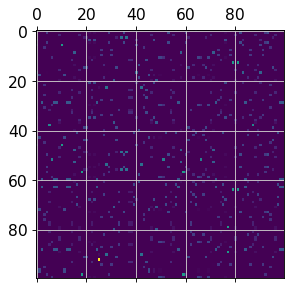

In [121]:
plt.matshow(dex_10_vs_saha_100[1])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'perturbation_raw' as categorical
... storing 'treatment' as categorical


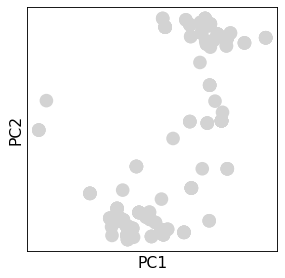

In [151]:
sc.pl.pca(sc.concat([dex_10,saha_100]))

<ipython-input-178-2999d596d700>:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(figures_path / 'transport_weights.pdf')
<ipython-input-178-2999d596d700>:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(figures_path / 'transport_weights.pdf')
/home/yavuz/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


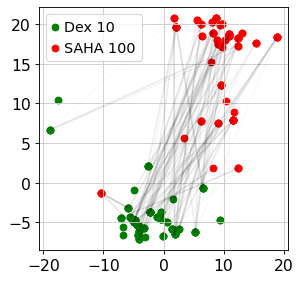

In [178]:
plt.scatter(dex_10.obsm['X_pca'][:,0], dex_10.obsm['X_pca'][:,1], c='g', label='Dex 10')
plt.scatter(saha_100.obsm['X_pca'][:,0], saha_100.obsm['X_pca'][:,1], c='r', label='SAHA 100')
for i in range(len(dex_10.obsm['X_pca'])):
    for j in range(i+1, len(dex_10.obsm['X_pca'])):
        transport_weight = dex_10_vs_saha_100[1][i,j].numpy().item()
        if  transport_weight != 0.0:
    #         plt.plot(dex_10.obsm['X_pca'][i,0], saha_100.obsm['X_pca'][i,1], alpha = transport_weight)
            plt.plot([dex_10.obsm['X_pca'][i,0], saha_100.obsm['X_pca'][i,0]], [dex_10.obsm['X_pca'][i,1], saha_100.obsm['X_pca'][i,1]], alpha=transport_weight * 10, c='black')
plt.legend(loc=)
plt.savefig(figures_path / 'transport_weights.pdf')

In [140]:
dex_10_vs_saha_100[1][0,0].numpy().item()

6.099115916940834e-37

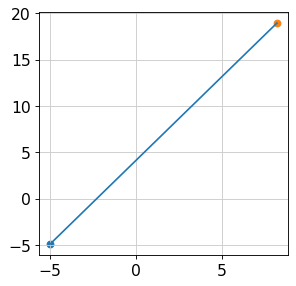

In [159]:
plt.scatter(dex_10.obsm['X_pca'][0,0], dex_10.obsm['X_pca'][0,1])
plt.scatter(saha_100.obsm['X_pca'][0,0], saha_100.obsm['X_pca'][0,1])
plt.plot([dex_10.obsm['X_pca'][0,0], saha_100.obsm['X_pca'][0,0]], [dex_10.obsm['X_pca'][0,1], saha_100.obsm['X_pca'][0,1]])

In [154]:
dex_10.obsm['X_pca'][0,0:2]

ArrayView([-4.984095 , -4.9219193], dtype=float32)

In [254]:
torch.from_numpy(pert2_data.obsm['X_pca'])

NameError: name 'pert2_data' is not defined

tensor(5.6797)
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
tensor([0.0324, 0.0337, 0.0349, 0.0341, 0.0304, 0.0346, 0.0340, 0.0333, 0.0343,
        0.0333, 0.0328, 0.0343, 0.0329, 0.0346, 0.0337, 0.0341, 0.0337, 0.0325,
        0.0304, 0.0304, 0.0331, 0.0323, 0.0336, 0.0349, 0.0341, 0.0346, 0.0342,
        0.0341, 0.0323, 0.0326])
tensor(1.0000)


<ipython-input-301-34e4780b994c>:24: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.scatter(rand1[:,0], rand1[:,1], c=result[1].sum(dim=1), vmin=0.0001, vmax=1, cmap='summer', norm=norm)
<ipython-input-301-34e4780b994c>:25: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.scatter(rand2[:,0], rand2[:,1], c=result[1].sum(dim=0), vmin=0.0001, vmax=1, cmap='autumn', norm=norm)


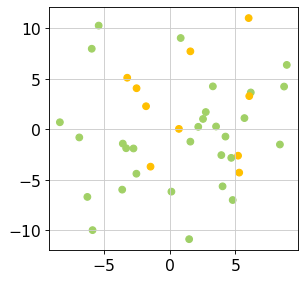

In [301]:
def dummy():
    pert1 = "['Dex', '10']"
    pert2 = "['SAHA', '10']"
    pert1_data = sample_sets[sample_labels.index(pert1)]
    pert2_data = sample_sets[sample_labels.index(pert2)]
#     print(torch.from_numpy(pert2_data.obsm['X_pca']).shape)
    sinkhorn_result = sinkhorn_cuturi(torch.from_numpy(pert1_data.obsm['X_pca'][:10]), torch.from_numpy(pert2_data.obsm['X_pca']))
    sinkhorn_result2 = sinkhorn_cuturi(torch.from_numpy(pert2_data.obsm['X_pca']), torch.from_numpy(pert1_data.obsm['X_pca']))
#     print(sinkhorn_result[1].sum())
#     print(sinkhorn_result[1].sum(dim=0))
#     print(sinkhorn_result[1].sum(dim=1))
#     print(sinkhorn_result2[1].sum())
#     print(sinkhorn_result2[1].sum(dim=0))
#     print(sinkhorn_result2[1].sum(dim=1))
    
    rand1 = torch.randn(30,2) * 5
    rand2 = torch.cat([torch.randn(10,2) * 5])
    result = sinkhorn_cuturi(rand1, rand2)
    print(result[0])
    print(result[1].sum(dim=0))
    print(result[1].sum(dim=1))
    print(result[1].sum())
    norm = colors.LogNorm()
    plt.scatter(rand1[:,0], rand1[:,1], c=result[1].sum(dim=1), vmin=0.0001, vmax=1, cmap='summer', norm=norm)
    plt.scatter(rand2[:,0], rand2[:,1], c=result[1].sum(dim=0), vmin=0.0001, vmax=1, cmap='autumn', norm=norm)

dummy()

In [312]:
def compare_perturbations(pert1, pert2):
    pert1_data = sample_sets[sample_labels.index(pert1)]
    pert2_data = sample_sets[sample_labels.index(pert2)]
    sinkhorn_result = sinkhorn_cuturi(torch.from_numpy(pert1_data.obsm['X_pca']), torch.from_numpy(pert2_data.obsm['X_pca']))
    sns.heatmap(sinkhorn_result[1], label='Transport Plan')
    transport_weights = sinkhorn_result[1].sum(dim=1)
    plt.figure()
    sns.scatterplot(x=pert1_data.obsm['X_pca'][:,0], y=pert1_data.obsm['X_pca'][:,1], hue=transport_weights, label=pert1, palette='autumn')
    sns.scatterplot(x=pert2_data.obsm['X_pca'][:,0], y=pert2_data.obsm['X_pca'][:,1], label=pert2, c='blue')
    
#     plt.scatter(pert2_data.obsm['X_pca'][:,0], pert2_data.obsm['X_pca'][:,1], c=transport_weights_pert2, label=pert2, cmap='autumn')
    for i in range(len(pert1_data.obsm['X_pca'])):
        for j in range(i+1, len(pert1_data.obsm['X_pca'])):
            transport_weight = sinkhorn_result[1][i,j].numpy().item()
            if  transport_weight != 0.0:
                
        #         plt.plot(dex_10.obsm['X_pca'][i,0], saha_100.obsm['X_pca'][i,1], alpha = transport_weight)
                plt.plot([pert1_data.obsm['X_pca'][i,0], pert2_data.obsm['X_pca'][i,0]], [pert1_data.obsm['X_pca'][i,1], pert2_data.obsm['X_pca'][i,1]], alpha=transport_weight * 10, c='black')
    plt.legend(loc='upper right', bbox_to_anchor=(1.5,1.0)) 
    plt.savefig(figures_path / f'transport_weights_{pert1}_{pert2}.pdf')

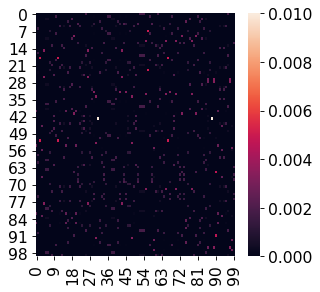

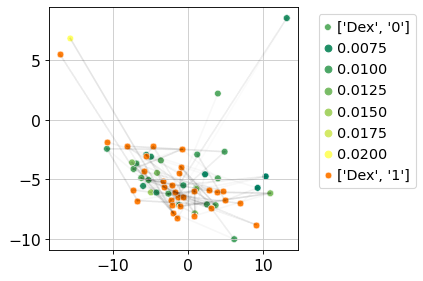

In [305]:
compare_perturbations("['Dex', '0']", "['Dex', '1']")

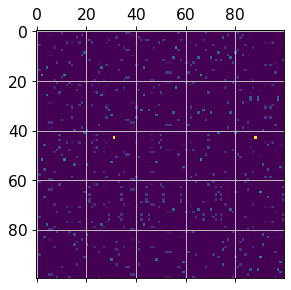

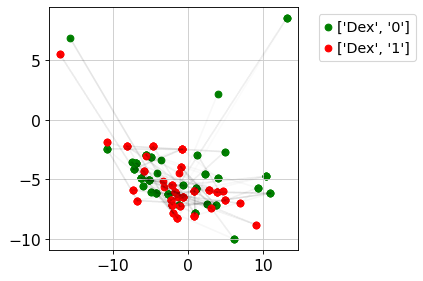

In [195]:
compare_perturbations("['Dex', '0']", "['Dex', '1']")

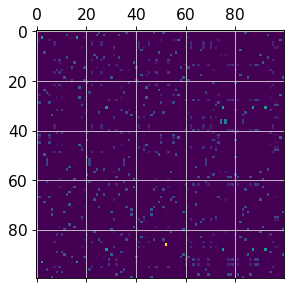

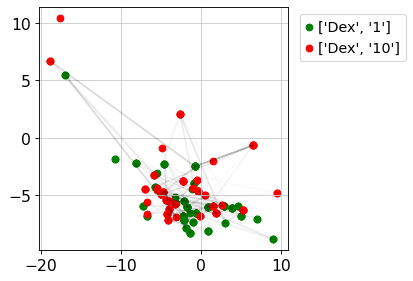

In [196]:
compare_perturbations("['Dex', '1']", "['Dex', '10']")

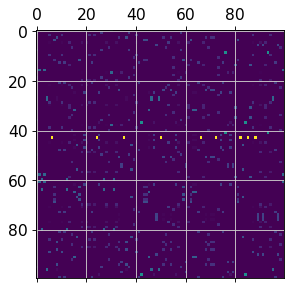

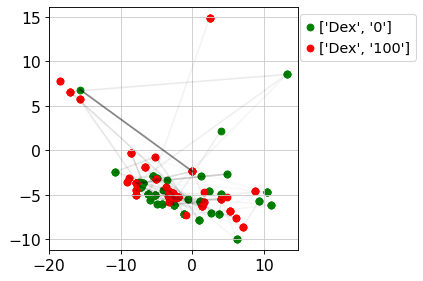

In [197]:
compare_perturbations("['Dex', '0']", "['Dex', '100']")

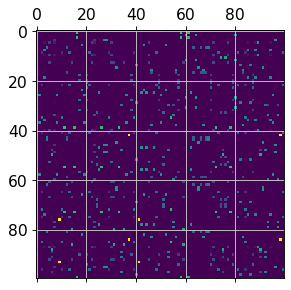

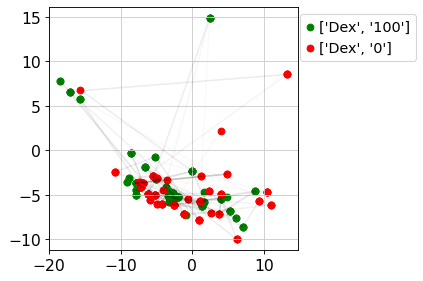

In [198]:
compare_perturbations("['Dex', '100']", "['Dex', '0']")

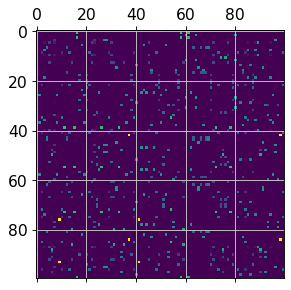

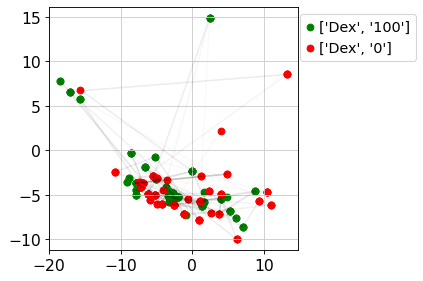

In [199]:
compare_perturbations("['Dex', '100']", "['Dex', '0']")

In [203]:
sinkhorn_cuturi(torch.from_numpy(dex_10.obsm['X_pca']), torch.from_numpy(saha_100.obsm['X_pca']))

(tensor(168.0833),
 tensor([[6.0991e-37, 1.0173e-30, 0.0000e+00,  ..., 1.9977e-03, 0.0000e+00,
          0.0000e+00],
         [4.5861e-26, 0.0000e+00, 0.0000e+00,  ..., 1.3865e-19, 0.0000e+00,
          0.0000e+00],
         [1.0744e-29, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [0.0000e+00, 2.0000e-03, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.5798e-42, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 4.2039e-45, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 tensor([[175.5598, 163.9262, 226.1122,  ..., 208.7227, 220.6382, 226.1122],
         [166.5353, 169.6173, 220.1689,  ..., 205.9231, 209.8216, 220.1689],
         [172.7467, 171.6732, 222.3658,  ..., 220.8990, 221.2407, 222.3658],
         ...,
         [148.4362, 128.0094, 212.1004,  ..., 206.6210, 210.0293, 212.1004],
         [178.9240, 184.7405, 230.6270,  ..., 227

In [204]:
sinkhorn_cuturi(torch.from_numpy(saha_100.obsm['X_pca']), torch.from_numpy(dex_10.obsm['X_pca']))

(tensor(169.0096),
 tensor([[0.0000e+00, 0.0000e+00, 7.2406e-21,  ..., 4.3721e-36, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.5330e-03, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 3.8995e-13,  ..., 0.0000e+00, 0.0000e+00,
          2.9760e-39],
         ...,
         [2.4999e-03, 1.1384e-33, 1.4719e-27,  ..., 0.0000e+00, 0.0000e+00,
          3.2090e-43],
         [0.0000e+00, 0.0000e+00, 1.0632e-37,  ..., 0.0000e+00, 0.0000e+00,
          1.7647e-22],
         [0.0000e+00, 0.0000e+00, 3.8995e-13,  ..., 0.0000e+00, 0.0000e+00,
          2.9760e-39]]),
 tensor([[175.5598, 166.5353, 172.7467,  ..., 148.4362, 178.9240, 179.2989],
         [163.9262, 169.6173, 171.6732,  ..., 128.0094, 184.7405, 165.8217],
         [226.1122, 220.1689, 222.3658,  ..., 212.1004, 230.6270, 228.4297],
         ...,
         [208.7227, 205.9231, 220.8990,  ..., 206.6210, 227.7790, 224.5554],
         [220.6382, 209.8216, 221.2407,  ..., 210

In [ ]:
sinkhorn_cuturi

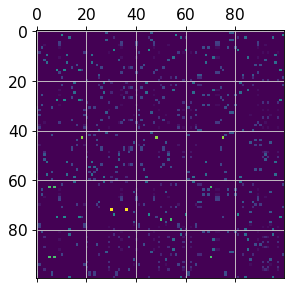

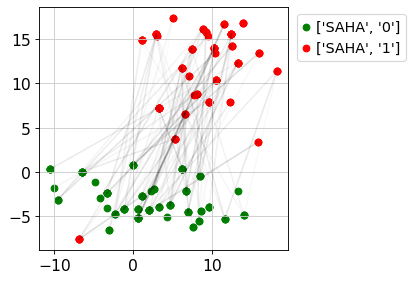

In [205]:
compare_perturbations("['SAHA', '0']", "['SAHA', '1']")

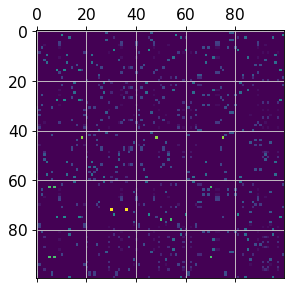

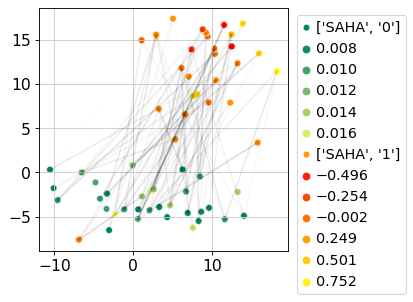

In [224]:
compare_perturbations("['SAHA', '0']", "['SAHA', '1']")

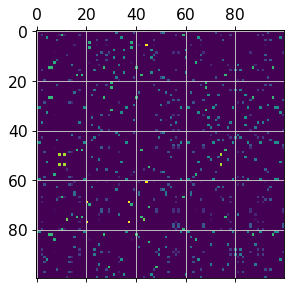

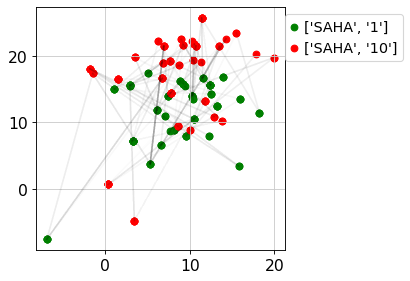

In [206]:
compare_perturbations("['SAHA', '1']", "['SAHA', '10']")

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not blue

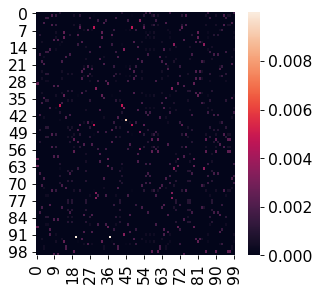

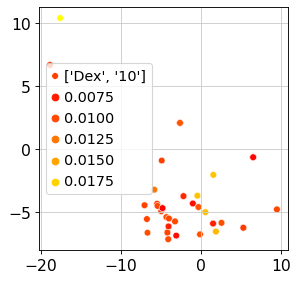

In [313]:
compare_perturbations("['Dex', '10']", "['SAHA', '10']")

In [315]:
!pip install pot

     |████████████████████████████████| 455 kB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 13.3 MB/s eta 0:00:01


In [316]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

In [343]:
n = 30  # nb samples
m = 20
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(m, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()

Text(0.5, 1.0, 'Cost matrix M')

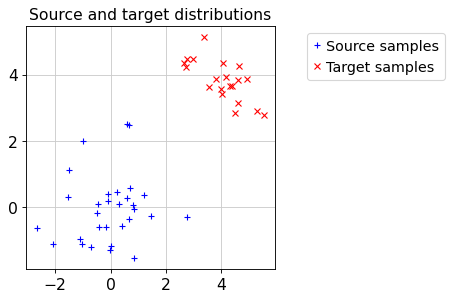

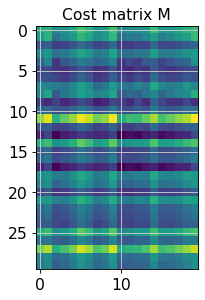

In [344]:
pl.figure(1)
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(bbox_to_anchor=(1.1,1))
pl.title('Source and target distributions')

pl.figure(2)
pl.imshow(M, interpolation='nearest')
pl.title('Cost matrix M')

In [336]:
G0.shape

(50, 10)

In [328]:
type(G0)

numpy.ndarray

In [339]:
np.sum(G0, axis=1)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [338]:
np.sum(G0, axis=0)

array([0.25, 0.25, 0.25, 0.25])

Text(0.5, 1.0, 'OT matrix with samples')

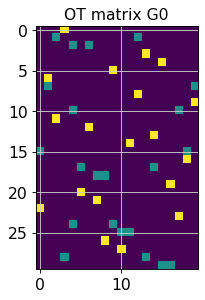

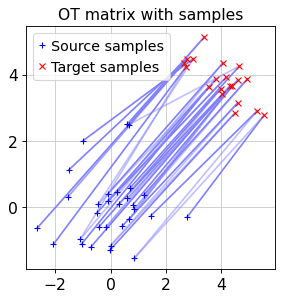

In [345]:
G0 = ot.emd(a, b, M)

pl.figure(3)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

Text(0.5, 1.0, 'OT matrix with samples')

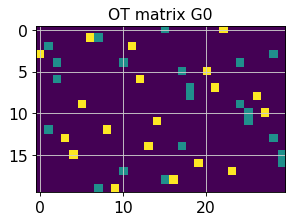

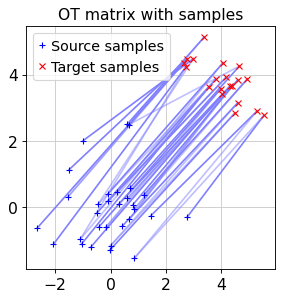

In [353]:
G1 = ot.emd(b, a, np.ascontiguousarray(M.T))

pl.figure(3)
pl.imshow(G1, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
ot.plot.plot2D_samples_mat(xt, xs, G1, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

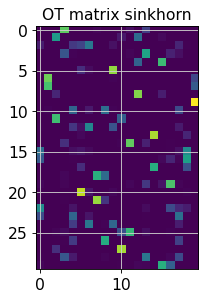

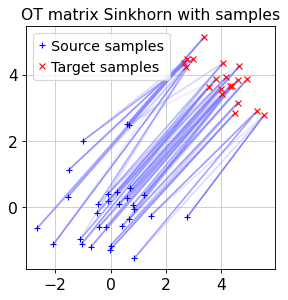

In [346]:
# reg term
lambd = 1e-3

Gs = ot.sinkhorn(a, b, M, lambd)

pl.figure(5)
pl.imshow(Gs, interpolation='nearest')
pl.title('OT matrix sinkhorn')

pl.figure(6)
ot.plot.plot2D_samples_mat(xs, xt, Gs, color=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix Sinkhorn with samples')

pl.show()

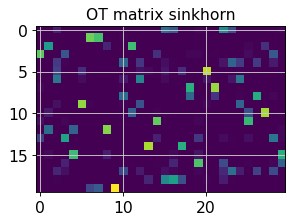

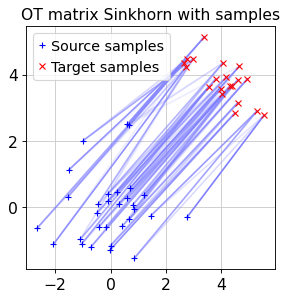

In [354]:
# reg term
lambd = 1e-3

Gst = ot.sinkhorn(b, a, np.ascontiguousarray(M.T), lambd)

pl.figure(5)
pl.imshow(Gst, interpolation='nearest')
pl.title('OT matrix sinkhorn')

pl.figure(6)
ot.plot.plot2D_samples_mat(xt, xs, Gst, color=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix Sinkhorn with samples')

pl.show()

In [359]:
Gst[10,0]

4.159153034738829e-09

Text(0.5, 1.0, 'OT matrix with samples')

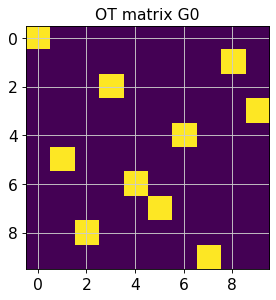

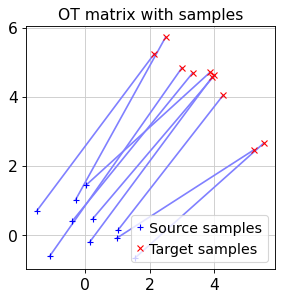

In [374]:
n = 10  # nb samples
m = 10
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(m, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()

G0 = ot.emd(a, b, M)

pl.figure(3)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

In [375]:
print(G0)

[[0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0. ]
 [0.  0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0.  0. ]
 [0.  0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.  0. ]]


In [362]:
print(G0.shape)
print(G0.sum())
print(G0.sum(axis=0))
print(G0.sum(axis=1))

(5, 10)
1.0
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.2 0.2 0.2 0.2 0.2]


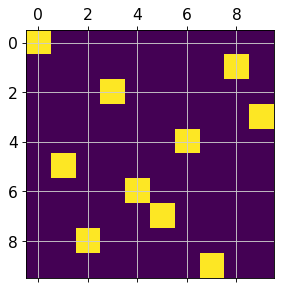

In [376]:
plt.matshow(G0)

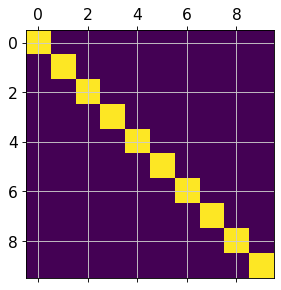

In [377]:
plt.matshow(G0 @ G0.T)

In [371]:
G0

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.1],
       [0. , 0.1, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0.1, 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.1, 0. , 0. ]])

In [370]:
G0 @ G0.T

array([[0.02, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.02, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.02]])

In [379]:
G0.T @ G0

array([[0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01]])

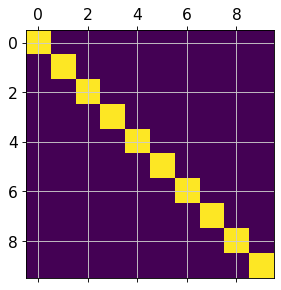

In [378]:
plt.matshow(G0.T @ G0)

Text(0.5, 1.0, 'OT matrix with samples')

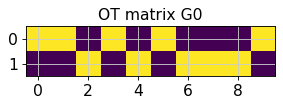

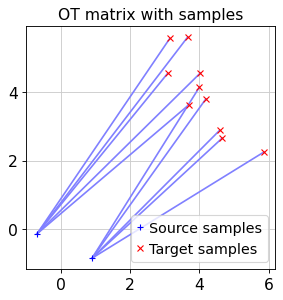

In [380]:
n = 2  # nb samples
m = 10
mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(m, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)
M /= M.max()

G0 = ot.emd(a, b, M)

pl.figure(3)
pl.imshow(G0, interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

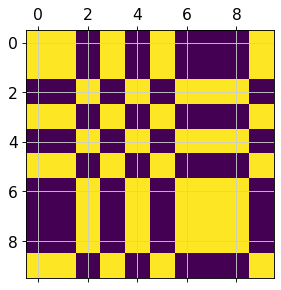

In [381]:
plt.matshow(G0.T @ G0)

In [389]:
G0[0,:]

array([1.00000000e-01, 1.00000000e-01, 0.00000000e+00, 1.00000000e-01,
       0.00000000e+00, 1.00000000e-01, 0.00000000e+00, 0.00000000e+00,
       2.77555756e-17, 1.00000000e-01])

In [384]:
G0.T @ G0

array([[1.00000000e-02, 1.00000000e-02, 0.00000000e+00, 1.00000000e-02,
        0.00000000e+00, 1.00000000e-02, 0.00000000e+00, 0.00000000e+00,
        2.77555756e-18, 1.00000000e-02],
       [1.00000000e-02, 1.00000000e-02, 0.00000000e+00, 1.00000000e-02,
        0.00000000e+00, 1.00000000e-02, 0.00000000e+00, 0.00000000e+00,
        2.77555756e-18, 1.00000000e-02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e-02, 0.00000000e+00,
        1.00000000e-02, 0.00000000e+00, 1.00000000e-02, 1.00000000e-02,
        1.00000000e-02, 0.00000000e+00],
       [1.00000000e-02, 1.00000000e-02, 0.00000000e+00, 1.00000000e-02,
        0.00000000e+00, 1.00000000e-02, 0.00000000e+00, 0.00000000e+00,
        2.77555756e-18, 1.00000000e-02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e-02, 0.00000000e+00,
        1.00000000e-02, 0.00000000e+00, 1.00000000e-02, 1.00000000e-02,
        1.00000000e-02, 0.00000000e+00],
       [1.00000000e-02, 1.00000000e-02, 0.00000000e+00, 1.00000000e-02,
   

In [383]:
G0 @ G0.T

array([[5.00000000e-02, 2.77555756e-18],
       [2.77555756e-18, 5.00000000e-02]])

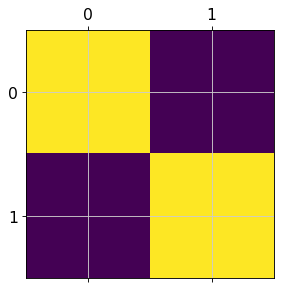

In [382]:
plt.matshow(G0 @ G0.T)